# Imports etc...

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import logging
%matplotlib inline

# Logging

In [2]:
import logging, sys

def init_logging():
    '''
    Initializes logging for this project.
    '''
    
    #--- refs: code taken from: https://docs.python.org/3/howto/logging-cookbook.html
    #--- https://stackoverflow.com/a/9321890
    #--- https://stackoverflow.com/a/56366848   to clear any existing loggers
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    logger = logging.getLogger()

    logging.basicConfig(
        level    = logging.DEBUG, 
        format   = '%(asctime)s | %(levelname)-8s | %(name)s: %(message)s',
        filename = 'adv_lane_find.log',
        filemode = 'w'
    )
        
    #--- console: INFO only, abbreviated format
    console = logging.StreamHandler(sys.stdout)
    console.setLevel(logging.INFO)
    console_formatter = logging.Formatter('%(levelname)-8s | %(name)s: %(message)s')
    console.setFormatter(console_formatter)
    logger.addHandler(console)
    
    return

# Camera Module
- ChessoardImage
- ChessboardCameraCalibrationSet
- Camera

In [3]:
class ChessboardImage:
    '''
    An image of a chessboard used to calibrate Camera.
    
    Methods:
    - __init__: specify base, filename, and inner square dims of chessboad image.
    - findChessboardCorners
    
    Notes:
    - objpoints and imgpoints are used to calibrate camera.
    - img_corners can be used to display the image to verify that corners were found correctly.
    '''
    
    def __init__ (self, base_path, filename, inner_dims):
        self.logger = logging.getLogger ("ChessboardImage")
        
        #--- RGB image of chessboard
        self.img = mpimg.imread(base_path + filename)
        self.filename = filename
        
        #---inner dimensions of chessboard
        self.xdim, self.ydim = inner_dims

        #--- object and image points used in findChessboardCorners()
        self.objpoints = None
        self.imgpoints = None
        
        #--- image of chessboard annotated with corners found
        self.img_corners = None
        
        msg = 'Image loaded for {} with dims {}.'
        self.logger.debug (msg.format(self.filename, (self.xdim, self.ydim)))
        
        return
    
    def findChessboardCorners(self):
        '''
        Finds the chessboard corners of the chessboard image.
        
        Returns:
        - corners_found: the image space coordinates of the corners of the chessboard image.
        
        '''
        
        #--- given the chessboard image and inner dimensions (xdim, ydim), find the chessboard corners 
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        corners_found, corners = cv2.findChessboardCorners(gray, (self.xdim, self.ydim), flags=None)
        
        if corners_found:
            #--- generate object points in the XY plane; Z=0
            #--- dimensions will be based on the chessboard_images
            #--- corners found are placed in an order from left to right, top to bottom
            #--- thereforem object points are generated in column (X) priority order
            #--- ref: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
            #--- object_points should be: (0,0,0), (1,0,0), (2,0,0)..(xdim-1,0,0), (1,1,0)...
            self.objpoints = np.zeros(shape=(self.xdim * self.ydim, 3), dtype=np.float32)
            self.objpoints[:, :2] = np.array([(x, y) for y in range(self.ydim) for x in range(self.xdim)])
            
            #--- save corners found to imgpoints
            self.imgpoints = corners
            
            #--- save image with corners annotated to img_corners
            self.img_corners = np.copy (self.img)
            self.img_corners = cv2.drawChessboardCorners(self.img_corners, (self.xdim, self.ydim), self.imgpoints, True)                 
            
            msg = "Found corners for {}."
            self.logger.debug (msg.format(self.filename))
        else:

            msg = "DID NOT FIND corners for {}, dims: {}."
            self.logger.warning (msg.format(self.filename, (self.xdims, self.ydims)))
            
        return corners_found
    
    
class ChessboardCameraCalibrationSet:
    '''
    Distortion calibration set for Camera.
    
    Methods:
    - __init__: specifies path, filenames and inner square dimensions chessboard images.
    - loadChessboardImages
    - findChessboardCorners
    - showCorners
    - getCalibrationParams
    - getChessboardImg
    '''
    
    def __init__(self):
        
        self.logger = logging.getLogger("ChessboardImages")
        
        #--- chessboard image meta data (basepath, filenames with inner dims, image shape)
        #--- base path to images
        self.basepath = 'camera_cal/'
        #--- image filenames with corresponding inner dimensions manually counted
        self.filenames_dims = [
            ('calibration1.jpg', (9,5)),
            ('calibration2.jpg', (9,6)),
            ('calibration3.jpg', (9,6)),
            ('calibration4.jpg', (5,6)),  #--- close corners, watch it
            ('calibration5.jpg', (7,6)),
            ('calibration6.jpg', (9,6)),
            ('calibration7.jpg', (9,6)),
            ('calibration8.jpg', (9,6)),
            ('calibration9.jpg', (9,6)),
            ('calibration10.jpg', (9,6)),
            ('calibration11.jpg', (9,6)),
            ('calibration12.jpg', (9,6)),
            ('calibration13.jpg', (9,6)),
            ('calibration14.jpg', (9,6)),
            ('calibration15.jpg', (9,6)),
            ('calibration16.jpg', (9,6)),
            ('calibration17.jpg', (9,6)),
            ('calibration18.jpg', (9,6)),
            ('calibration19.jpg', (9,6)),
            ('calibration20.jpg', (9,6)),
             ]
        
        #--- shape of all images in cols,rows; for later use in calibrate camera
        self.image_shape = (1280, 720)
        
        #--- a list of data about the boards: (RGB image of board, XY inner dimensions, filename)
        self.chessboard_images = []
        
        #--- objpoints and imgpoints used for camera calibration
        #--- will be compiled in findChessboardCorners
        self.objpoints = []
        self.imgpoints = []
        
        return

    def loadChessboardImages(self):
        '''Loads chessboard images into self.chessboard_images; call before using find chessboard corners.'''
        
        msg = "Loading chessboard images..."
        self.logger.info (msg)
        
        for filename_dim in self.filenames_dims:
            
            filename = filename_dim[0]
            dims     = filename_dim[1]
            
            #--- read in files
            chessboard_image = ChessboardImage (self.basepath, filename, dims)
            self.chessboard_images.append(chessboard_image)
            
        msg = "...completed loading chessboard images."
        self.logger.info (msg)
        
        return
    
    def findChessboardCorners(self):
        '''
        Finds chessboard corners for each chessboard; call loadchessboardimages before this call.
        
        Notes:
        - Calls each chessboard image to find corners
        - Collects chessboard image objpoints and imgpoints to self.objpoints and self.imgpoints
        '''

        msg = "Finding chessboard corners..."
        self.logger.info (msg)
        
        for chessboard_image in self.chessboard_images:
            if chessboard_image.findChessboardCorners():
                #--- imgpoints[i] corresponds to objpoints[i]
                self.imgpoints.append (chessboard_image.imgpoints)
                self.objpoints.append (chessboard_image.objpoints)
            
        msg = "...completed finding chessboard corners."
        self.logger.info (msg)
        
        return
    
    def getCalibrationParams(self):
        '''
        Returns the parameters needed to calibrate Camera.
        
        Returns:
        - objpoints, imgpoints: objpoints and imgpoints generated from findChessboardCorners.
        - image_shape: shape of image of chessboard images
        
        Notes:
        - objpoints, imgpoints, image_shape will be used in camera calibration
        '''
        self.loadChessboardImages()
        self.findChessboardCorners()
        
        return (self.objpoints, self.imgpoints, self.image_shape)
    

    def showCorners(self, ncols=1):
        '''
        Displays images of the chessboard with all chessboard corners annotated.
        
        Params:
        - ncols: number of columns to fit all the images into.
        '''
        
        nimgs = len(self.chessboard_images)
        nrows = nimgs // ncols + (nimgs % ncols)
        plt.figure(figsize=(16, 10 * (nrows + 1) // ncols))
        for idx, chessboard_image in enumerate (self.chessboard_images):
            ax = plt.subplot(nrows, ncols, idx + 1)
            ax.imshow(chessboard_image.img_corners)
            ax.set_title(chessboard_image.filename)
        return
    
    def getChessboardImg(self, idx=0):
        '''
        Returns an image of a chessboard for inspection
        
        Params:
        - idx: index of chessboard image to inspect
        '''
        
        return self.chessboard_images[idx].img
    

class Camera:
    '''
    Creates image corrected for distortion.
    
    Methods:
    - __init__
    - calibrateCamera: call before using undistort().
    - undistort
    '''
    
    
    def __init__ (self):
        
        self.logger = logging.getLogger("Camera")
        
        #--- camera matrix
        self.mtx = None
        
        #--- distortion coefficient
        self.dist = None
        
        #--- image shape in X,Y (numcols, numrows)
        self.image_shape = None
        
        return
    

    def calibrateCamera (self, calibration_set=None):
        '''
        Calculates the camera matrix and distortion coefficients used to correct distortion.
        
        Params:
        - calibration_set: a class with a function called getCalibrationParams that returns
        objpoints, imgpoints, and image_shape used for camera calibration
        '''
        
        if calibration_set is None:
            calibration_set = ChessboardCameraCalibrationSet()
            
        objpoints, imgpoints, self.image_shape = calibration_set.getCalibrationParams ()
        
        #--- rotation and translation vectors not used for this project
        cal_found, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, self.image_shape, None, None)
        
        if cal_found:
            msg = "Camera calibrated."
            self.logger.info(msg)            
        else:
            msg = "Camera was not calibrated."
            self.logger.warning(msg)            
        
        return

    
    def undistort(self, img):
        '''
        corrects image distortion
        
        Paramters:
        - img: image to apply distortion correction
        
        Returns:
        - img_undist: the undistorted image
        
        Notes:
        - img_undist should then be fed to the LaneEnhancer 
        
        '''
        
        img_undist = cv2.undistort(img, self.mtx, self.dist)
        
        return img_undist
    

# LaneEnhancer
- LaneEnhancer

In [4]:
class LaneEnhancer:
    '''
    Enhances appearance of road lanes using edge detection and color channels.
    
    Methods:
    - __init__
    - Sobel_x
    - s_channel
    - enhance: combine Sobel_x gradient and s_channel thresholding
    '''
    
    def SobelX(self, img, t_min=20, t_max=255):
        '''
        Detects edges by measuring gradients along x axis.
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for gradient along x axis to trigger edge detection
        
        Returns:
        - mask: a binary image highlighting where edges were detected
        '''
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        
        #--- activate (set to "1") all pixels that meet the x gradient thresholds
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def SChannel (self, img, t_min=125, t_max=255):
        '''
        Detects pixels meeting s_channel thresholds.
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for s_channel detection; default threshold values
        were manually chosen for enhancing yellow and white pixels of road lanes
        
        Returns:
        - mask: a binary image highlighting where pixels met the s_channel threshold 
        for yellow and white colors
        '''
        
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        #--- extract the s_channel frol hls
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        
        #--- activate all pixels that meet the s-channel threshold
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
    def enhance(self, img):
        '''
        Combines SobelX and SChannel methods for enhancing lanes
        
        Params:
        - img: an RGB image of road to enhance

        Returns:
        - a binary image resulting from bitwise "or" of sobel and s-channel masks
        '''
        
        sobel_mask     = self.SobelX (img)
        s_channel_mask = self.SChannel(img)
        
        return sobel_mask | s_channel_mask    

# Warper Module
- TopDownWarperCalibrationSet
- ImageWarper

In [5]:
class TopDownWarperCalibrationSet:
    '''
    Data for calculating transformation matrix for an ImageWarper
    
    Methods:
    - __init__
    - showPoints
    
    Notes:
    - Persective transforms using this calibration set result in a top-down view
    - This is the default calibration set for ImageWarper
    '''    
    
    def __init__(self):
        
        #--- save image calibration points were based off of
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        '''
        Older src and dest points that worked but not as good as final
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        
        return
    
    def showPoints(self):
        '''
        plots src and dst points on image calibration points were based off of
        '''
        
        plt.figure(figsize=(11, 6.5))

        ax = plt.sublot(121)
        for i in range(4):
            ax.plot(src_points[i][0], src_points[i][1], '.')
        return
        ax.imshow(self.img)
        
        ax = plt.sublot(122)
        for i in range(4):
            ax.plot(dst_points[i][0], dst_points[i][1], '.')
        return
        ax.imshow(self.img)

        
class ImageWarper:
    '''
    Warps and dewarps images.
    
    Methods:
    - __init__()
    - warpPerspective()
    - unWarpPerspective()

    Notes:
    -  transforms (warps) an image for use by a LaneDetector
    '''

    def __init__(self, calibration_set=None):
        '''
        Calculates the transform and inverse tranformation matrices
        
        Params:
        - calibration set: set of src are dst points of the form [[x1, y2], [x2, y2], ...];
        src points are points on original image; dst points are points that the src points
        will be transformed to
        '''
        
        #--- set default calibration set to top-down perspective
        if calibration_set is None:
            calibration_set = TopDownWarperCalibrationSet()
        
        #--- M: transformation matrix
        self.M = cv2.getPerspectiveTransform(calibration_set.src_points, 
                                             calibration_set.dst_points)
        
        #--- use invM when unwarping image
        self.invM = cv2.getPerspectiveTransform(calibration_set.dst_points, 
                                                calibration_set.src_points)
        
        return
        
    def warpPerspective(self, img):
        '''
        warps perspective based on transformation_matrix
        
        Params:
        - img: the image to be distorted; can be RGB or gray scale
        
        Returns:
        - img_warped: the image with the per
        
        Notes:
        - Undistort img with an camera instance before warping
        '''
        
        img_warped = cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        return img_warped
    
    def unwarpPerspective(self, img):
        
        img_unwarped = cv2.warpPerspective(img, self.invM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        return img_unwarped

# LaneLineGenerator
- SlidingWindow
- LinearWindow
- Line
- LaneLineFinder
- LeftLaneFinder
- RightLaneFinder

In [6]:
class SlidingWindow:
    '''
    Finds lane line points using a sliding window search area.

    Methods:
    - __init__
    - reinit: reinitializes variables so instance can be reused
    - 

    Notes:
    - Lane line points are points on the image that belong to a lane in the road
    '''
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def reinit (self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):
        '''
        Reinitializes the variables to reuse the instace. Simply calls __init__.
        '''
        
        self.__init__(x_mid, target_ht, image_points, 
                 num_segments, x_offset, numpoints_found_thresh)
        return
        
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        Returns:
        - (lane_points_x, lane_points_y): a tuple of all the x points and y points of the image
        that belong to the lane; so that the following is a point in the image 
        that belongs to the lane (lane_points_x[i], lane_points_y[i]); the points can then be used
        in poly_fit to estimate the lane line (i.e. polyfit (y_lane_points, x_lane_points))
        
        Notes:
        - Accumulates points found in lane_points_x and _y
        - Calls slideUp() at the end to prepare the window to detect the next set of points
        - mid_x updated to average if the number of points found exceed threshold
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return (self.lane_points_x, self.lane_points_y)
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LinearWindow:
    '''
    Find points of a road lane in an image that are within a certain offset of a line.
    
    Methods:
    - __init__
    - reinit
    - findpoints
    
    Notes:
    - A lane line found in a previous frame by SlidingWindow or LinearWindow is used
    to start the search.
    '''
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        '''
        Defines the boarders of the linear search area along line.
        
        Params:
        - line: a line found a previous frame of the road
        - target_ht: height of the road image being examined
        - image_points: all nonzero points of the image if the form [[x1, x2, ...], [y1, y2, ...]]
        - x_offset: the offset along the x-axis of line to determine search area
        '''
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        #--- x1 and x2 define the borders/extents of the search area about the line
        #--- use line.X() to generate the x points of the border
        self.x1 = line.X(self.image_points_y) - x_offset
        #--- add offset twice to x1 to get right border of the search area
        self.x2 = self.x1 + x_offset + x_offset
        
        #--- lane points have not been found yet
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    def reinit (self, line, target_ht, image_points, x_offset=100):
        '''Reinitializes to reuse instance.'''
        
        self.__init__(line, target_ht, image_points, x_offset)
        
        return
    
    def findPoints (self):
        '''
        Collects all the points of the image within the linear border.
        
        Returns:
        - lane_points_x, lane_points_y: points on the road image that are part of the lane;
        these lane points are of the for [x1, x2, ...] and [y1, y2, ...] and are
        fed to polyfit to determine the line that fits the area define by the lane points.
        '''
        
        #--- mask in all points within linear window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points 
        #--- that are in linear window search area 
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return self.lane_points_x, self.lane_points_y
    

class Line:
    '''
    A line representing a lane on the road.

    Methods:
    - __init__: calls fitpoly immediately
    '''
    
    def __init__(self, x, y, polyfit_tries = 10):
        '''
        Sets the coefficients of the line through polyfit.
        
        Params:
        - x, y: coordinates of points to fit line
        
        Notes:
        - Makes up to default 10 attempts with error checking for a successful fit.
        - Coefficients are set to none if no line found
        '''
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        tries = 0
        self.line_found = False
        while not self.line_found:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + c
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                self.line_found = True
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                else:
                    msg = "Polyfit failed to fit a line. {}."
                    self.logger.warning(msg.format(e))
                    break
                    
                    
        if self.line_found:
            self.a = fit[0]   # coeff for y**2
            self.b = fit[1]   # coeff for y
            self.c = fit[2]   # constant
        else:
            self.a = None
            self.b = None
            self.c = None
            
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        
        parameters:
        - img_ht: height of image
        
        returns:
        - x_points: array of the x coordinates of the line in int32, none if line was not found
        - y_points: array of y coordinates of the line in int32, none if line was not found
        '''
        
        if not self.line_found:
            return None, None
        
        #--- generate y points from 0 to img_ht - 1, cast to int32 for ease of plotting
        y_line_points = np.int32 (np.array([float(y) for y in range(img_ht)]))
                                 
        #--- calculate points based on x, cast to int32 for ease of plotting
        x_line_points = np.int32 (self.X(y_line_points))
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        
        Params:
        - y: an array of y values
        
        Returns:
        - x: an array calculate by ay**2 + by + c; None if line was not found
        '''
        
        if not self.line_found:
            return None
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x

    
class LaneLineFinder:
    """
    Finds a line representing the lane of a road.
    
    Methods:
    - __init__
    - updateXStart: need to implement in Child Class
    - findImagePoints
    - getSlidingWindow
    - getLinearWindow
    - selectLanePointsFinder
    - checkLaneLine
    - getPaintPoints
    - paint
    """
    
    def __init__(self):
        
        self.logger = logging.getLogger("LaneDetector")
        
        #--- topdown image of the road in binary format; should be fed in from ImageWarper
        self.binary_warped = None
        
        #--- x value where sliding window starts its search
        self.x_start       = None
        
        #--- nonzero points of road image
        self.image_points  = None
        self.lane_lines    = []
        
        #--- must be a class that implements findPoints() and finds the points of the lane
        self.lane_points_finder = None
        self.sliding_window = None
        self.linear_window = None
        
        #--- points of the lane line in ([[x1, y1], [x2, y2], ...) format that is used in cv2 drawing functions
        self.paint_points = None
        
        return
    
    def updateXStart(self):
        '''
        Set that value of x_start used to begin the search using slidingWindow.
        
        Note:
        - The method for setting the x_start depends on left or right sidedness of lane;
        it should be implemented in the child class
        '''
        
        raise NotImplementedError()
        
    def findImagePoints(self):
        '''
        Find all nonzero points on the image
        
        Returns:
        - image_points_x, image_points_y: the x and y coordinates of all the nonzero points of the image;
        the LaneFinder will search through these coordinates to find the points that are part of the lane
        '''
        
        nonzero_points = np.nonzero(self.binary_warped)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        image_points_y = np.array(nonzero_points[0])
        image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (image_points_x, image_points_y)
        
        return 
    
    def getSlidingWindow(self):
        '''
        Returns a sliding window used to search image_points for the points of the lane.
        
        Returns:
        - sliding_window
        
        Notes:
        - If a sliding window instance already exists, it is reinitialized and reused.
        - The starting X position must always be calculated and set for the sliding window.
        '''

        self.updateXStart()
        if self.sliding_window:
            #--- resuse existing and reinitizalize instance
            self.sliding_window.reinit(self.x_start,
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.sliding_window = SlidingWindow(self.x_start,
                                               target_ht    = self.binary_warped.shape[0],
                                               image_points = self.image_points)
        
        return self.sliding_window
        
    def getLinearWindow(self):
        '''
        Returns a linear_window used to search image_points for the points of the line.
        
        Returns:
        - linear_window
        
        Notes:
        - There must be at least one line detected previously; it is used as the basis
        for the search area for the linear window.
        '''
        
        last_lane_line = self.lane_lines[-1]
        if self.linear_window:
            #--- reuse and reinitizalize existing instance
            self.linear_window.reinit(last_lane_line, 
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.linear_window = LinearWindow(last_lane_line,
                                              target_ht    = self.binary_warped.shape[0],
                                              image_points = self.image_points)            
        return self.linear_window
        
    def selectLanePointsFinder(self):
        '''
        Selects the approriate LanePointsFinder to search for lane points.
        '''
        
        if self.lane_lines:
            #--- use LinearWindow if lane lines were previously found
            self.lane_points_finder = self.getLinearWindow()
        else:
            #--- use sliding window if lane lines were NOT previously found
            self.lane_points_finder = self.getSlidingWindow()
            
        return
            
    def checkLaneLine(self, line):
        #--- TODO: code this!!!
        pass
    
    def findLaneLine (self, binary_warped):
        '''
        Finds line representing lane of the road using appropriate lane line finder.
        '''
        
        self.binary_warped = binary_warped
        
        self.findImagePoints()
        self.selectLanePointsFinder()
        
        x_lane_points, y_lane_points = self.lane_points_finder.findPoints()
        
        lane_line = Line(x_lane_points, y_lane_points)
        
        if lane_line is not None:
            self.checkLaneLine(lane_line)
            self.lane_lines.append(lane_line)
        
        return 
    
    def getPaintPoints(self, canvas, flipud=False):
        '''
        Returns an array of points repesenting the line of the lane.
        
        Params:
        - canvas: an RGB image painting area; just needed to get 
        the height of the canvas to generate the set of points.
        - flipud: option for returning the array of points in reverse order.
        
        Returns:
        - an array of points like [[[x1, y1], [x2, y2], ...]], shape is like (1, numpoints, 2).

        Notes:
        - Points are suitable for using in cv2 draw functions
        - If no lanes were found, returns None
        - Set flipud (flip unside down) to true; this is useful for flipping an oppposite lane
        to form a polygon for a fillpoly call
        
        '''

        if not self.lane_lines:
            return None

        if self.paint_points is None: 
            curr_lane_line = self.lane_lines[-1]
            x_points, y_points = curr_lane_line.generatePoints(canvas.shape[0])

            #--- combine and transform x_ and y_points to [[x1, y1], [x2, y2], ...]
            self.paint_points = np.array([(np.transpose(np.vstack((x_points, y_points))))])
            
        if flipud:
            #--- if you flipud(paint_points), it will be the same 
            #--- since there is only 1 element in first dimension
            #--- first element of paint_points contains the actual points
            #--- so flipud (paint_points[0]) then apply np.array([])
            return np.array([np.flipud(self.paint_points[0])])
        
        else:
            return self.paint_points
    
    def paint (self, canvas):
        '''
        Paints the points of the line
        '''
        
        if self.lane_lines:
            cv2.polylines(canvas, 
                          pts       = self.getPaintPoints(canvas), 
                          isClosed  = False, 
                          color     = [255, 0, 0],    #--- default red line color
                          thickness = 20)        
        return
    
        
class LeftLaneLineFinder(LaneLineFinder):
    '''
    LaneLineFinder for left lane.
    
    Methods:
    - updateXStart: implements base to set the x_start of the LaneLineGenerator
    '''

    def updateXStart(self):
        
        #--- get bottom half of image for histogram
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        #--- search only **left** half of histogram
        mid_x = histogram.shape[0] // 2
        self.x_start = np.argmax(histogram[:mid_x])
        
        return
    
    
class RightLaneLineFinder(LaneLineFinder):
    '''
    LaneLineFinder for right lane.
    
    Methods:
    - updateXStart: implements base to set the x_start of the LaneLineGenerator
    '''
    
    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        #--- search only **right** half of histogram
        mid_x = histogram.shape[0] // 2
        self.x_start = mid_x + np.argmax(histogram[mid_x:])
        
        return

In [7]:
class LaneLinesAnnotator:
    
    def __init__(self):
        
        self.left_lane_line_finder  = LeftLaneLineFinder()
        self.right_lane_line_finder = RightLaneLineFinder()
        return
        
    def findLanes(self, binary_warped):
    
        self.left_lane_line_finder.findLaneLine(binary_warped)
        self.right_lane_line_finder.findLaneLine(binary_warped)
        
        return
    
    def paint(self, binary_warped):
        
        #--- create the canvas for painting
        #--- black canvas [0 0 0 ...]
        canvas_binary = np.zeros_like(binary_warped).astype(np.uint8)
        #--- black RGB canvass [[0 0 0], [0 0 0], [0 0 0], ...]
        canvas = np.dstack((canvas_binary, canvas_binary, canvas_binary))
        
        #--- tell left and right lane detectors to paint their portion on canvas
        self.left_lane_line_finder.paint(canvas)
        self.right_lane_line_finder.paint(canvas)
        
        #--- get polygon for lane area by getting paint points of each lane finder
        left_lane_paint_points = self.left_lane_line_finder.getPaintPoints(canvas)
        
        #--- need to "reverse" right points array so tail of pts_left is next to head of pts_right
        #--- this ordering allows fillpoly to traverse around perimeter, 
        #--- if the order of points is not flipud, the fill will look like a bowtie
        right_lane_paint_points = self.right_lane_line_finder.getPaintPoints(canvas, flipud=True)
        
        if left_lane_paint_points is not None and right_lane_paint_points is not None:
            #--- combaine paintpoints into a polygon
            lane_area_paint_pts = np.hstack((left_lane_paint_points, right_lane_paint_points))

            #--- paint the lane area
            cv2.fillPoly(canvas, lane_area_paint_pts, [0,255,0])

        return canvas
    
        

In [8]:
init_logging()
camera              = Camera()
lane_enhancer       = LaneEnhancer()
image_warper        = ImageWarper()
lane_lines_annotator = LaneLinesAnnotator()

In [9]:
camera.calibrateCamera()

INFO     | ChessboardImages: Loading chessboard images...
INFO     | ChessboardImages: ...completed loading chessboard images.
INFO     | ChessboardImages: Finding chessboard corners...
INFO     | ChessboardImages: ...completed finding chessboard corners.
INFO     | Camera: Camera calibrated.


In [10]:
img = mpimg.imread('camera_cal/calibration1.jpg')
img_undistorted = camera.undistort(img)


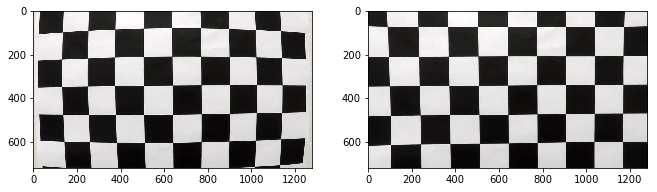

In [11]:
plt.figure(figsize=(11, 6.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(img)
ax2.imshow(img_undistorted)

# warped = camera.warpPerspective(curved_img)
# plt.imshow(warped)

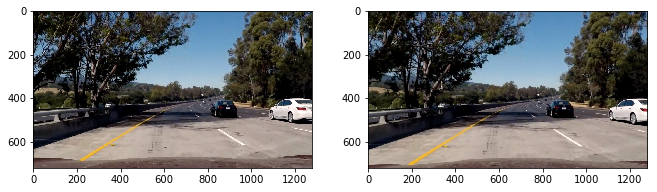

In [25]:
img = mpimg.imread('test_images/test5.jpg')
img_undistorted = camera.undistort(img)
plt.figure(figsize=(11, 6.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(img)
ax2.imshow(img_undistorted)


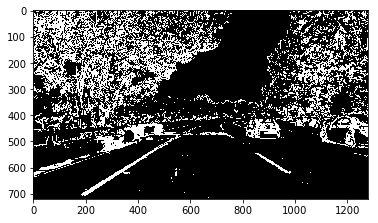

In [26]:
binary = lane_enhancer.enhance(img_undistorted)
plt.imshow(binary, cmap='gray')

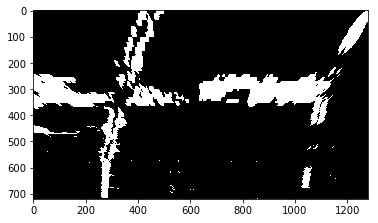

In [27]:
binary_warped = image_warper.warpPerspective(binary)
plt.imshow(binary_warped, cmap='gray')

WARNING  | Line: Polyfit failed: SVD did not converge in Linear Least Squares. Trying again.
WARNING  | Line: Polyfit succeeded on try 2.


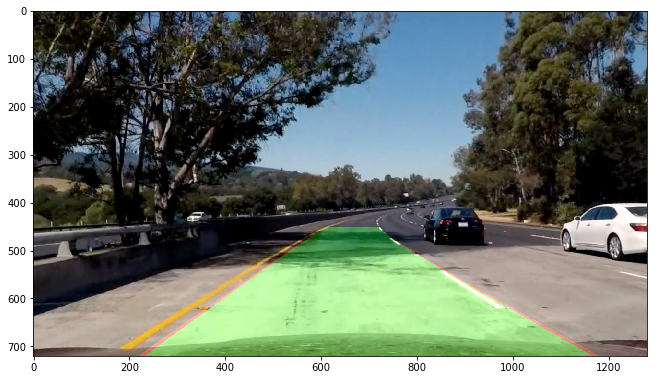

In [28]:
lane_lines_annotator.findLanes(binary_warped)
canvas = lane_lines_annotator.paint(binary_warped)

unwarpcanvas = image_warper.unwarpPerspective(canvas)
result = cv2.addWeighted(img_undistorted, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [ ]:
    
    
'''
BaselineImage: use for setting setting transformation matrix
'''    
class BaselineImage:
    
    def __init__(self):
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        
        return
    
    def showSrcPoints(self):
        plt.imshow(img)
        for i in range(4):
            plt.plot(source_points[i][0], source_points[i][1], '.')
        return
    
    
    
   
    

In [ ]:
init_logging()

chessboard_images = ChessboardImages()
chessboard_images.loadChessboardImages() 
chessboard_images.findChessboardCorners()
camera = Camera()


In [ ]:
logging.shutdown()

In [ ]:
camera.calibrateCamera(chessboard_images)
idx=0
img = camera.undistort(chessboard_images.getChessboardImg(idx))
plt.subplot(121).imshow(chessboard_images.getChessboardImg(idx))
plt.subplot(122).imshow(img)

logging.shutdown()

In [ ]:
baseline_image = BaselineImage()
camera.updateM(baseline_image.src_points, baseline_image.dst_points)
warped = camera.warpPerspective(camera.baseline_image.img)
plt.imshow(warped)

In [ ]:
curved_img = mpimg.imread('test_images/straight_lines1.jpg')
warped = camera.warpPerspective(curved_img)
plt.imshow(warped)

In [ ]:
unwarped = camera.unwarpPerspective(warped)
plt.imshow(unwarped)

Gradient and Colorspace

In [ ]:
'''
    def h_channel (self, img, t_min=18, t_max=50):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        
        mask = np.zeros_like(h_channel)
        mask[(t_min <= h_channel) & (h_channel <= t_max)] = 1
        
        return mask
    
    
    #--- we reuse the test_highlight_yellow_and_white above
    def yellow_white(self, img):

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        mask_yellow = cv2.inRange(hsv, yellow_range[0], yellow_range[1])
        mask_white  = cv2.inRange(hsv, white_range[0], white_range[1])

        mask = mask_yellow + mask_white

        return mask
yellow_range = [np.array([20,  70,   0]), 
                np.array([40, 255, 255])]

white_range  = [np.array([  0,  0, 180]), 
                np.array([179, 25, 255])]

        

'''


class LaneEdgeMasker:
    def __init__(self):
        
        return
    
    def Sobel_x(self, img, t_min=20, t_max=255):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def s_channel (self, img, t_min=125, t_max=255):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
masker = LaneEdgeMasker()



In [ ]:
x_mask = masker.Sobel_x(curved_img)
plt.imshow(x_mask, cmap='gray')

In [ ]:
x_warped = camera.warpPerspective(x_mask)
plt.imshow(x_warped, cmap='gray')

In [ ]:
s_mask = masker.s_channel(curved_img)
plt.imshow(s_mask, cmap='gray')

In [ ]:
s_warped = camera.warpPerspective(s_mask)
plt.imshow(s_warped, cmap='gray')

In [ ]:
all_mask = s_warped | x_warped
plt.imshow(all_mask, cmap='gray')

Finding the lines

In [ ]:
def hist(mask):
    
    bottom_half = mask[mask.shape[0] // 2:,:]
    hist = np.sum(bottom_half, axis=0)
    
    return hist

h = hist(all_mask)
plt.plot(h)
print (h.shape)
    
    

get starting points

In [ ]:
mid_x = h.shape[0] //2

left_x_mid = np.argmax(h[:mid_x])
right_x_mid = mid_x + np.argmax(h[mid_x:])
print (left_x_mid, right_x_mid)
print (h[left_x_mid], h[right_x_mid])

In [ ]:
class OldSlidingWindow:
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        - Accumulates points found in lane_points
        - Call slideUp() after findPoints, otherwise, duplicate points may be collected
        - mid_x updated to average of x points found
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return 
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LineWindow:
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        self.x1 = line.X(self.image_points_y) - x_offset
        self.x2 = self.x1 + x_offset + x_offset
        
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    
    def findPoints (self):
        
        #--- mask in all points within window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points that are in window region
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return
        


class OldLine:
    
    def __init__(self, x, y, polyfit_tries = 10):
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        
        tries = 0
        while True:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + C
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                break
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                    continue
                else:
                    msg = "Polyfit failed. {}."
                    self.logger.error(msg)
                    
        '''
        fit = np.polyfit(y, x, deg=2)
        
        '''
                
        self.a = fit[0]   # coeff for y**2
        self.b = fit[1]   # coeff for y
        self.c = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        '''
        
        #--- generate y points from 0 to img_ht - 1
        y_line_points = np.array([float(y) for y in range(img_ht)])
                                 
        #--- calculate points based on x
        x_line_points = self.X(y_line_points)
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        '''
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x
        
        
class LineGenerator:
    
    def __init__(self, lane_warped_img_binary):
        
        self.img_binary   = lane_warped_img_binary
        
        
    def findStartingX(self):
        
        y_mid = self.img_binary.shape[0] // 2
        img_binary_bottom_half = self.img_binary[y_mid:, :]
        
        hist    = np.sum(img_binary_bottom_half, axis=0)
        x_mid   = self.img_binary.shape[1] // 2
        
        self.x_start_left  = np.argmax(hist[:x_mid])
        self.x_start_right = np.argmax(hist[x_mid:]) + x_mid
        
        return
    
    
    def findImagePoints(self):
        
        nonzero_points = np.nonzero(self.img_binary)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        self.image_points_y = np.array(nonzero_points[0])
        self.image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (self.image_points_x, self.image_points_y)
        
        return 
        
        
    def findLinesDemo(self):
        
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        self.findStartingX()
        self.findImagePoints()
        
        left_window     = SlidingWindow(self.x_start_left,  self.img_binary.shape[0], self.image_points)
        right_window    = SlidingWindow(self.x_start_right, self.img_binary.shape[0], self.image_points)

        lines_found  = []
        windows      = [left_window, right_window]
        point_colors = [[255, 0, 0], [0, 0, 255]]
        for window, point_color in zip(windows, point_colors):
            
            window.findPoints()
                    
            if window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(window.lane_points_x, window.lane_points_y)
                lines_found.append(line)
                demo_img[window.lane_points_y, window.lane_points_x] = point_color

        plt.figure(figsize=(11, 6.5))
        for line in lines_found:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            plt.plot(x_line_points, y_line_points, color='yellow')
        plt.imshow(demo_img)
        
        return lines_found
    
    
    def findLines(self):
        
        self.findStartingX()
        self.findImagePoints()
        
        left_window  = SlidingWindow(self.x_start_left,  self.img_binary.shape[0], self.image_points)
        right_window = SlidingWindow(self.x_start_right, self.img_binary.shape[0], self.image_points)

        self.lines_found  = []
        windows      = [left_window, right_window]
        for window in windows:
            
            window.findPoints()
                    
            if window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(np.array(window.lane_points_x), np.array(window.lane_points_y))
                self.lines_found.append(line)

        return self.lines_found
    
    
    def findLinesLineWindow(self):
        
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        line_windows = []
        for line in self.lines_found:
            line_window = LineWindow(line, self.img_binary.shape[0], self.image_points)
            line_windows.append(line_window)

        self.lines_found = []
        for line_window in line_windows:
            line_window.findPoints()
            
            if line_window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(line_window.lane_points_x, line_window.lane_points_y)
                self.lines_found.append(line)
            
        plt.figure(figsize=(11, 6.5))
        for line in self.lines_found:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            plt.plot(x_line_points, y_line_points, color='yellow')
        plt.imshow(demo_img)
        
        return
        
        
            
lineGenerator = LineGenerator(all_mask)       


# AdvancedLaneDetector

In [ ]:
lines = lineGenerator.findLines()
print (lines[0].a)

In [ ]:
lines = lineGenerator.findLinesLineWindow()

In [ ]:
x = np.array([34, 35, 12 , 45, 56])
y = np.array([432, 123, 40 , 125, 456])
m = (12 <= x) & (x <= 35)
n = (430 <= y) & (y <= 435)
print (m)
print (n)
x_points = x[m & n]
y_points = y[m & n]
print (np.stack((x_points, y_points)))

In [ ]:
class SlidingWindow:
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def reinit (self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):
        
        self.__init__(x_mid, target_ht, image_points, 
                 num_segments, x_offset, numpoints_found_thresh)
        return
        
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        - Accumulates points found in lane_points
        - Call slideUp() after findPoints, otherwise, duplicate points may be collected
        - mid_x updated to average of x points found
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return (self.lane_points_x, self.lane_points_y)
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LinearWindow:
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        self.x1 = line.X(self.image_points_y) - x_offset
        self.x2 = self.x1 + x_offset + x_offset
        
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    
    def reinit (self, line, target_ht, image_points, x_offset=100):
        
        self.__init__(self, line, target_ht, image_points, x_offset)
        
        return

    
    
    def findPoints (self):
        
        #--- mask in all points within window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points that are in window region
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return self.lane_points_x, self.lane_points_y
    

class Line:
    '''
    descritpion


    '''
    
    def __init__(self, x, y, polyfit_tries = 10):
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        
        tries = 0
        while True:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + C
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                break
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                    continue
                else:
                    msg = "Polyfit failed. {}."
                    self.logger.error(msg)
                    
        '''
        fit = np.polyfit(y, x, deg=2)
        
        '''
                
        self.a = fit[0]   # coeff for y**2
        self.b = fit[1]   # coeff for y
        self.c = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        
        parameters:
        - img_ht: height of image
        
        returns:
        - x_points: array of the x coordinates of the line in int32
        - y_points: array of y coordinates of the line in int32
        '''
        
        #--- generate y points from 0 to img_ht - 1, cast to int32 for ease of plotting
        y_line_points = np.int32 (np.array([float(y) for y in range(img_ht)]))
                                 
        #--- calculate points based on x, cast to int32 for ease of plotting
        x_line_points = np.int32 (self.X(y_line_points))
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        
        - returns x as
        '''
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x

    
class LaneDetector:
    
    def __init__(self):
        
        self.logger = logging.getLogger("LaneDetector")
        
        self.binary_warped = None
        
        self.x_start       = None
        self.image_points  = None
        self.lane_lines    = []
        
        #--- must be a class that implements findPoints() and returns a Line
        self.lane_points_finder = None
        self.sliding_window = None
        self.linear_window = None
        
        #--- points of the lane line in ([[x1, y1], [x2, y2], ...) format that is used in cv2 drawing functions
        self.paint_points = None
        
        return
    
    def updateXStart(self):
        
        raise NotImplementedError()
        
    def getLaneColor(self):
        '''
        gets color used for painting lane line
        
        - defaults to red
        - change in descendent classes to 
        '''
        
        return [255, 0, 0]
    
    def findImagePoints(self):
        
        nonzero_points = np.nonzero(self.binary_warped)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        image_points_y = np.array(nonzero_points[0])
        image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (image_points_x, image_points_y)
        
        return 
    
    def getSlidingWindow(self):

        self.updateXStart()
        if self.sliding_window:
            #--- resuse existing and reinitizalize instance
            self.sliding_window.reinit(self.x_start,
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.sliding_window = SlidingWindow(self.x_start,
                                               target_ht    = self.binary_warped.shape[0],
                                               image_points = self.image_points)
        
        return self.sliding_window
        
    def getLinearWindow(self):
        last_lane_line = self.lane_lines[-1]
        if self.linear_window:
            #--- reuse and reinitizalize existing instance
            self.linear_window.reinit(last_lane_line, 
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.linear_window = LinearWindow(last_lane_line)
            
        return self.linear_window
        
    def selectLanePointsFinder(self):
        
        if self.lane_lines:
            self.lane_points_finder = self.getLinearWindow()
        else:
            self.lane_points_finder = self.getSlidingWindow()
            
        return
            
    def checkLaneLine(self, line):
        #--- TODO: code this!!!
        pass
    
    def findLaneLine (self, binary_warped):
        
        self.binary_warped = binary_warped
        
        self.findImagePoints()
        self.selectLanePointsFinder()
        
        x_lane_points, y_lane_points = self.lane_points_finder.findPoints()
        
        lane_line = Line(x_lane_points, y_lane_points)
        
        self.checkLaneLine(lane_line)
        self.lane_lines.append(lane_line)
        
        return 
    
    def getPaintPoints(self, canvas, flipud=False):
        '''
        Returns an array of points repesenting the line of the lane
        
        Params:
        - canvas: an RGB image painting area; just needed to get 
        the height of the canvas to generate the set of points
        - flipud: option for returning the array of points in reverse order
        
        Returns:
        - an array of points like [[[x1, y1], [x2, y2], ...]], shape is like (1, numpoints, 2)

        - points are suitable for using in cv2 draw functions
        - if no lanes were found, returns None
        - set flipud (flip unside down) to true; this is useful for flipping an oppposite lane
        to form a polygon for a fillpoly call
        
        '''

        if not self.lane_lines:
            return None

        if self.paint_points is None: 
            curr_lane_line = self.lane_lines[-1]
            x_points, y_points = curr_lane_line.generatePoints(canvas.shape[0])

            #--- combine and transform x_ and y_points to [[x1, y1], [x2, y2], ...]
            self.paint_points = np.array([(np.transpose(np.vstack((x_points, y_points))))])
            
        if flipud:
            #--- if you flipud(paint_points), it will be the same 
            #--- since there is only 1 element in first dimension
            #--- first element of paint_points contains the actual points
            #--- so flipud (paint_points[0]) then apply np.array([])
            return np.array([np.flipud(self.paint_points[0])])
        
        else:
            return self.paint_points
    
    def paint (self, canvas):
        '''
        paints the points of the line
        '''

        cv2.polylines(canvas, 
                      pts       = self.getPaintPoints(canvas), 
                      isClosed  = False, 
                      color     = [255, 0, 0],    #--- default red line color
                      thickness = 20)        
        return
    
        
class LeftLaneDetector(LaneDetector):

    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        mid_x = histogram.shape[0] // 2
        self.x_start = np.argmax(histogram[:mid_x])
        
        return
    
    
class RightLaneDetector(LaneDetector):
    
    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        mid_x = histogram.shape[0] // 2
        self.x_start = mid_x + np.argmax(histogram[mid_x:])
        
        return

In [ ]:
ald = AdvancedLaneDetector()
ald.findLanes(all_mask)

In [ ]:
canvas = ald.paint(all_mask)
plt.figure(figsize=(11, 6.5))
plt.imshow(canvas)


In [ ]:
unwarpcanvas = camera.unwarpPerspective(canvas)
result = cv2.addWeighted(curved_img, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [ ]:
canvas_binary = np.zeros_like(all_mask).astype(np.uint8)
canvas = np.dstack((canvas_binary, canvas_binary, canvas_binary))
canvas.shape

In [ ]:
plt.imshow(canvas)

In [ ]:
lx_points, ly_points = ald.left_lane.generatePoints(canvas.shape[0])
rx_points, ry_points = ald.right_lane.generatePoints(canvas.shape[0])

In [ ]:
plt.figure(figsize=(11, 6.5))
plt.plot(lx_points, ly_points, color='yellow')
plt.plot(rx_points, ry_points, color='yellow')
plt.imshow(canvas)


In [ ]:
plt.figure(figsize=(11, 6.5))

pts_left = np.array([(np.transpose(np.vstack((lx_points, ly_points))))])
pts_right = np.array([np.flipud(np.transpose(np.vstack((rx_points, ry_points))))])
pts = np.hstack((pts_left, pts_right))
print (pts.shape)

cv2.fillPoly(canvas, np.int_([pts]), [0,255,0])
cv2.polylines(canvas, pts_left, False, [255,0,0], 8)
cv2.polylines(canvas, pts_right, False, [255,0,0], 8)


plt.imshow(canvas)
print (canvas.shape)

In [ ]:
unwarpcanvas = camera.unwarpPerspective(canvas)
result = cv2.addWeighted(curved_img, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [ ]:
a = np.array([])
if a.size > 0:
    print('not empty')

In [ ]:
x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]
np.transpose (np.vstack((x,y)))

In [ ]:
a = np.array([[1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5]])
s = np.sum(a, axis=0)
print(s.shape)

In [ ]:
a3 = np.array( [[[10,10],[100,10],[100,100],[10,100]]], dtype=np.int32 )
a3.shape

In [ ]:
a3 = np.array( [[[10,10],[100,10],[10,100], [150,100]]], dtype=np.int32 )
im = np.zeros([240,320],dtype=np.uint8)
cv2.fillPoly( im, a3, 255 )

plt.imshow(im)
plt.show()

In [ ]:
def f(a):
    a = 10
    return a

x = 1
x = f(x)
print(x)

In [ ]:
img = mpimg.imread('test_images/straight_lines1.jpg')

ht = img.shape[0] - 1
wid = img.shape[1] - 1
midx = wid // 2
offsetx = 40
top = 425
bottom = ht

#--- XY coords
dx1 = 211
dx2 = 230


'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[191, 0],      [1123, 0],     [1123, 719], [211, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])

'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[391, 0],      [923, 0],     [923, 719], [391, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])



print (source_points)
print (dest_points)

plt.imshow(img)
for i in range(4):
    plt.plot(source_points[i][0], source_points[i][1], '.')



In [ ]:
M = cv2.getPerspectiveTransform(source_points, dest_points)
warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
# warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [ ]:



camera.getPerspectiveTransform(source_points, dest_points)
warped = camera.warpPerspective(img)
plt.imshow(warped)

In [ ]:
ret, corners = cv2.findChessboardCorners(gray, (9, 5), None)
if ret:
    print (corners.shape)

In [ ]:
#--- chessboard dimensions is in X by Y where X is columns, Y is rows

obj_points = np.zeros((9*5, 3), np.float32)
obj_points_2 = np.zeros((9*5, 3), np.float32)

#--- points are on the XY plane, so Z = 0
obj_points[:, :2] = np.mgrid[:9, :5].T.reshape(-1, 2)
obj_points_2[:, :2] = np.array([(x, y) for y in range(5) for x in range (9)])

# np.mgrid[:9, :5].T.reshape(-1, 2)
same = obj_points == obj_points_2
#print (same)
print (obj_points[:5])
print (obj_points_2[:5])

In [ ]:
mgrid = np.mgrid[:9, :5]
print (mgrid.shape)
print (mgrid)

In [ ]:
print (mgrid.T.shape)
print (mgrid.T)

In [ ]:
print (mgrid.T.reshape(-1, 2))
print (mgrid.T.shape)

In [ ]:
coords = mgrid.T.reshape(-1, 2)

In [ ]:
print (coords.shape)
print (corners.shape)
print (corners)

In [ ]:
img = cv2.drawChessboardCorners(img, (9, 5), corners, ret)
plt.imshow(img)

In [ ]:
shape = (4, 5, 3, 2, 8)
shape[2::2]